# Blind source separation
The purpose of the project is to separate an image obtained as a sum of a two images into its components. 

The two images img1 and img2 summed together come from different dataset: mnist and fashion_mnist, respectively.

No preprocessing is allowed. The network takes in input the sum img1+img2 and returns the predicted components hat_img1 and hat_img2. 

The metric used to evaluate the project is the mean squared error between predicted and ground truth images.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist

import numpy as np
from matplotlib import pyplot as plt

Here we load the two datasets, mnist and fashion mnist (both in grayscale).

For simplicity, the samples are padded to dimension (32,32).

In [ ]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
4431872/4422102 [==============================] - 0s 0us/step
(60000, 32, 32)


In [ ]:
print(np.shape(mnist_x_train))

(60000, 32, 32)


In [ ]:
print(np.shape(mnist_x_test))

(10000, 32, 32)


Here is a simple datagenerator.

In [ ]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_data, y_data 

Here we define two generators, one for training and one for testing. You may possibly add an addition generator for validation, further splitting the dataset.

In [ ]:
batchsize = 32
inputShape = (32,32,1)

Validation  Set

here we are deriving a 10000 samples of validation set from the training set

In [ ]:
mnist_x_train_org = mnist_x_train[:50000]
mnist_x_val = mnist_x_train[50000:]

In [ ]:
fashion_mnist_x_train_org = fashion_mnist_x_train[:50000]
fashion_mnist_x_val = fashion_mnist_x_train[50000:]

In [ ]:
print("Training Mnist Set: ",mnist_x_train_org.shape)
print("Validation Mnist Set: ",mnist_x_val.shape)
print("Training Fashion Mnist Set: ",fashion_mnist_x_train_org.shape)
print("Validation Fashion Mnist Set: ",fashion_mnist_x_val.shape)

Training Mnist Set:  (50000, 32, 32)
Validation Mnist Set:  (10000, 32, 32)
Training Fashion Mnist Set:  (50000, 32, 32)
Validation Fashion Mnist Set:  (10000, 32, 32)


# Data Generators (Train, Test, Val):

Here we define three generators, one for training, one for testing, one for validation by splitting the dataset.

In [ ]:
train_generator = datagenerator(mnist_x_train_org,fashion_mnist_x_train_org,batchsize)

test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,batchsize)

val_generator = datagenerator(mnist_x_val,fashion_mnist_x_val,batchsize)

Let us look at some input-output pairs

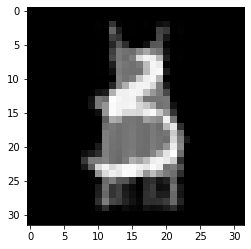

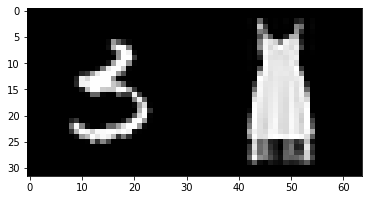

In [ ]:
x, y = next(train_generator)
plt.imshow(x[0],cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y[0], cmap='gray', interpolation='nearest')
plt.show()

# Model

here i have modeled an nn with auto encoders.
auto encoders are consists of
- 1.encoder 
- 2.bottleneck
- 3.decoder

Encoder: a module that compresses the train validate test set input data into encoded representationthat iis several order of magnitube smaller than input.

Bottleneck: the module that has the compessed knowledge representation.

Decoder: finally decoder is a set of unsampling blocks that reconstruct from the bottlenecks output 

In [ ]:
model = tf.keras.models.Sequential([
    # Encoding
    tf.keras.layers.Flatten(input_shape=inputShape),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(254, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'), #bottleneck
    # Decoding
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2048, activation='sigmoid'),
    tf.keras.layers.Reshape((32, 64))
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 254)               130302    
                                                                 
 dense_2 (Dense)             (None, 64)                16320     
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 512)               66048     
                                                                 
 dense_5 (Dense)             (None, 2048)              1

# Optimizer

 it is useful lower the learning rate as the training progresses.so, we used a scheduler. This scheduler applies an exponential decay function to an optimizer step, given a provided initial learning rate.

Then we need to compile the network.
In order to do it, we need to pass two mandatory arguments:


*   the **optimizer**, in charge of governing the details of the backpropagation algorithm
*   the **loss function*

In [ ]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)
    return lr

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    10.0,
    10000,
    decay_rate=0.99,
)
optimizer = tf.optimizers.Adamax(learning_rate=lr_schedule)
lr_metric = get_lr_metric(optimizer)

model.compile(optimizer='adamax',loss=tf.keras.losses.MeanSquaredError(),metrics=['mse'])

# Training the Model

we start training our model with train data to learn from

In [ ]:
history = model.fit(x=train_generator,
                    epochs=20,
                    steps_per_epoch=50000 // batchsize,
                    validation_data=val_generator,
                    validation_steps=10000 // batchsize)

Epoch 1/20
1562/1562 [==============================] - 43s 27ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0251 - val_mse: 0.0251
Epoch 2/20
1562/1562 [==============================] - 42s 27ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0201 - val_mse: 0.0201
Epoch 3/20
1562/1562 [==============================] - 42s 27ms/step - loss: 0.0184 - mse: 0.0184 - val_loss: 0.0173 - val_mse: 0.0173
Epoch 4/20
1562/1562 [==============================] - 42s 27ms/step - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 5/20
1562/1562 [==============================] - 42s 27ms/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0147 - val_mse: 0.0147
Epoch 6/20
1562/1562 [==============================] - 41s 26ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 7/20
1562/1562 [==============================] - 41s 26ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 8/20
1562/1562 [==========================

# Visualization (Training Loss vs Validation Loss)

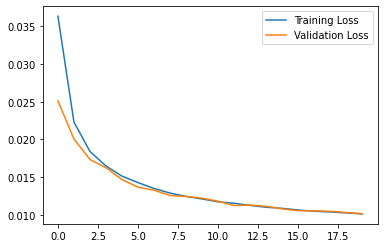

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

# Model Evaluate

the evaluate() Returns the loss value & metrics values for the model in test mode. we use test data to evaluate

In [ ]:
metrics = model.evaluate(test_generator, steps=10000 // batchsize)

312/312 [==============================] - 2s 7ms/step - loss: 0.0100 - mse: 0.0100


In [ ]:
print('Validation Mean Squared Error: {:.4f}'.format(metrics[1]))

Validation Mean Squared Error: 0.0100


# Predictions

here we can see how our model is predicting result of the test data

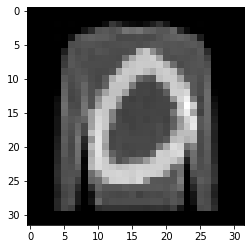

Text(0.5, 1.0, 'Prediction')

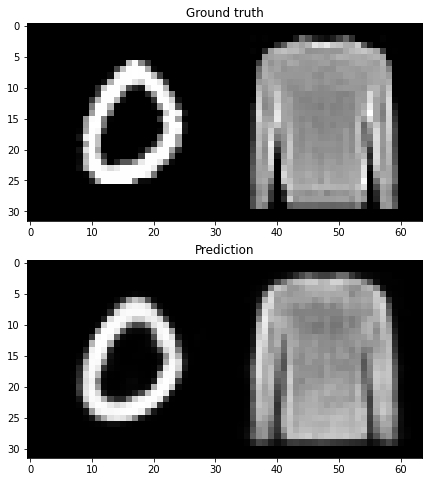

In [ ]:
x, y = next(test_generator)
plt.imshow(x[0],cmap='gray', interpolation='nearest')
plt.show()
y_predict = model.predict(x)
f, axarr = plt.subplots(2, figsize=(8, 8))
axarr[0].imshow(y[0], cmap='gray', interpolation='nearest')
axarr[0].set_title('Ground truth')
axarr[1].imshow(y_predict[0], cmap='gray', interpolation='nearest')
axarr[1].set_title('Prediction')

# Standard Deviation 

here we took samples from the test dataset and evaluated to find the standard deviation.

In [ ]:
metrics = []
for i in range(0,10):
  metric = model.evaluate(test_generator, steps=10000 // batchsize)
  #mse
  metrics.append(metric[1])

312/312 [==============================] - 2s 8ms/step - loss: 0.0101 - mse: 0.0101


In [ ]:
print("Standard Deviation :",np.std(metrics))

Standard Deviation : 2.8654572418964127e-05


see as expected the standard deviation is in the  order of 0.0193 